# <h1>DSF HOMEWORK 2</h1>

<h2> Name= Ritu Kaushik </h2> 

<h2>Student ID= 111499580</h2>

<p>Import all the required libraries</p>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn import ensemble
import lightgbm as lgb


import warnings

color = sns.color_palette()

%matplotlib inline

warnings.filterwarnings('ignore')

<p> Read the train dataset and print head of the dataset to see all the column names<p>

In [2]:
train_data= pd.read_csv("../Desktop/Zillow/train_2016_v2.csv") #Read Train Data

train_data.shape

train_data.head()

,parcelid,logerror,transactiondate
0,11016594,0.0276,2016-01-01
1,14366692,-0.1684,2016-01-01
2,12098116,-0.0040,2016-01-01
3,12643413,0.0218,2016-01-02
4,14432541,-0.0050,2016-01-02


<p> Read the property dataset and print size of the dataset<p>

In [3]:
property_data = pd.read_csv("../Desktop/Zillow/properties_2016.csv") #Read Property Data

property_data.shape

(2985217, 58)

# Data Analysis

<p> Let's start our data analysis. Let us see how the number of transactions vary in the data based on the month of the year. (Answer 2. #Plot 1)

</p>

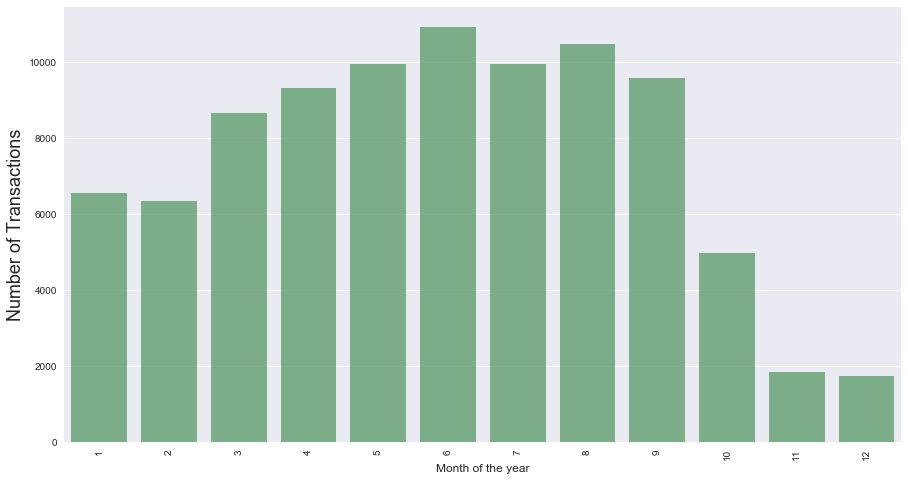

In [4]:
#1. bar chart
train_data['transactiondate']=pd.to_datetime(train_data['transactiondate'])
train_data['transaction_month'] = train_data['transactiondate'].dt.month
count_data = train_data['transaction_month'].value_counts()
plt.figure(figsize=(15,8))
sns.barplot(count_data.index, count_data.values, alpha=0.8, color=color[1])
plt.xticks(rotation='vertical')
plt.xlabel('Month of the year', fontsize=12)
plt.ylabel('Number of Transactions', fontsize=18)
plt.show()

<p> So, here we see that most of the houses were sold during the period of May-August (June being the highest)
As we could see from the data page as well The train data has all the transactions before October 15, 2016, plus some of the transactions after October 15, 2016. So we have shorter bars in the last three months.</p>

In [5]:
# drop the extra column added for analysis
train_data=train_data.drop(['transaction_month'], axis=1)

# Handling missing data

<p> Now, let us analye the missing values in our property data. We draw a bar chart to see the number of null values in each column</p>

[<matplotlib.text.Text at 0x1047606a0>, <matplotlib.text.Text at 0x10fbf29e8>]

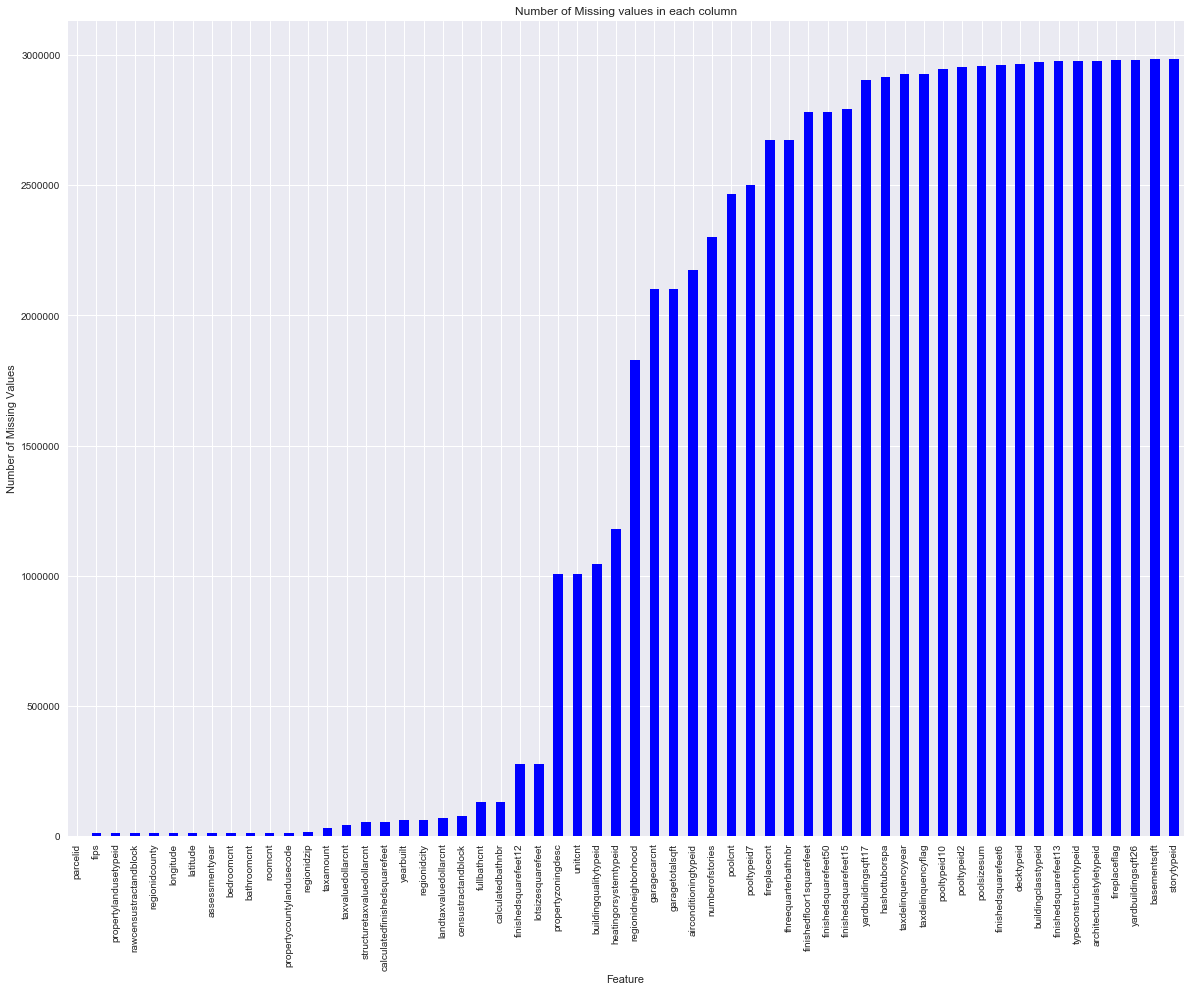

In [6]:
#Analysing each column for missing values

missing_data=property_data.isnull().sum(axis=0).sort_values()

ax=missing_data.plot.bar(figsize=(20,15), title='Number of Missing values in each column',color='blue')

ax.set(xlabel="Feature", ylabel="Number of Missing Values")

<p> So now, we will drop all the columns which have more than 50% missing values</p>

In [7]:
#drop columns having more than 50% missing data
output=property_data.dropna(thresh=0.5*len(property_data), axis=1) 

<p> We need to replace the remaining missing values with the mean value of that column for each column. Before this, we need to make sure that all column types are numeric before evaluating the mean</p>

In [8]:
#As we can see, we have two columns whose data types are 'objects', so we need to drop them before replacing with mean values
category_cols=output.select_dtypes(['object']).columns
output.drop(output[category_cols],axis=1, inplace=True)
output.head()


,parcelid,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,...,regionidzip,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock
0,10754147,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,...,96337.0,0.0,NaN,NaN,NaN,9.0,2015.0,9.0,NaN,NaN
1,10759547,0.0,0.0,NaN,NaN,NaN,NaN,6037.0,NaN,NaN,...,96337.0,0.0,NaN,NaN,NaN,27516.0,2015.0,27516.0,NaN,NaN
2,10843547,0.0,0.0,NaN,NaN,73026.0,NaN,6037.0,NaN,NaN,...,96095.0,0.0,2.0,NaN,650756.0,1413387.0,2015.0,762631.0,20800.37,NaN
3,10859147,0.0,0.0,7.0,NaN,5068.0,NaN,6037.0,NaN,NaN,...,96424.0,0.0,NaN,1948.0,571346.0,1156834.0,2015.0,585488.0,14557.57,NaN
4,10879947,0.0,0.0,NaN,NaN,1776.0,NaN,6037.0,NaN,NaN,...,96450.0,0.0,1.0,1947.0,193796.0,433491.0,2015.0,239695.0,5725.17,NaN


<p>Here, I am replacing all the na values with the mean values</p>

In [9]:
#fill missing values with mean
for column in output.columns:
    output[column]=output[column].fillna(output[column].mean())

<p>Finally, we can join the two datasets on the column 'Parcelid' as it is common in both</p>

In [10]:
#perform join operation on property and train data table with common parcelid

merged = output.merge(train_data, on='parcelid') 
merged.columns

Index(['parcelid', 'bathroomcnt', 'bedroomcnt', 'buildingqualitytypeid',
       'calculatedbathnbr', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'fips', 'fullbathcnt', 'heatingorsystemtypeid',
       'latitude', 'longitude', 'lotsizesquarefeet', 'propertylandusetypeid',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidzip', 'roomcnt', 'unitcnt', 'yearbuilt',
       'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'assessmentyear',
       'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror',
       'transactiondate'],
      dtype='object')

# Plotting different features

<p>Now, we will plot the scatter plot of how each feature varies with the log error</p>

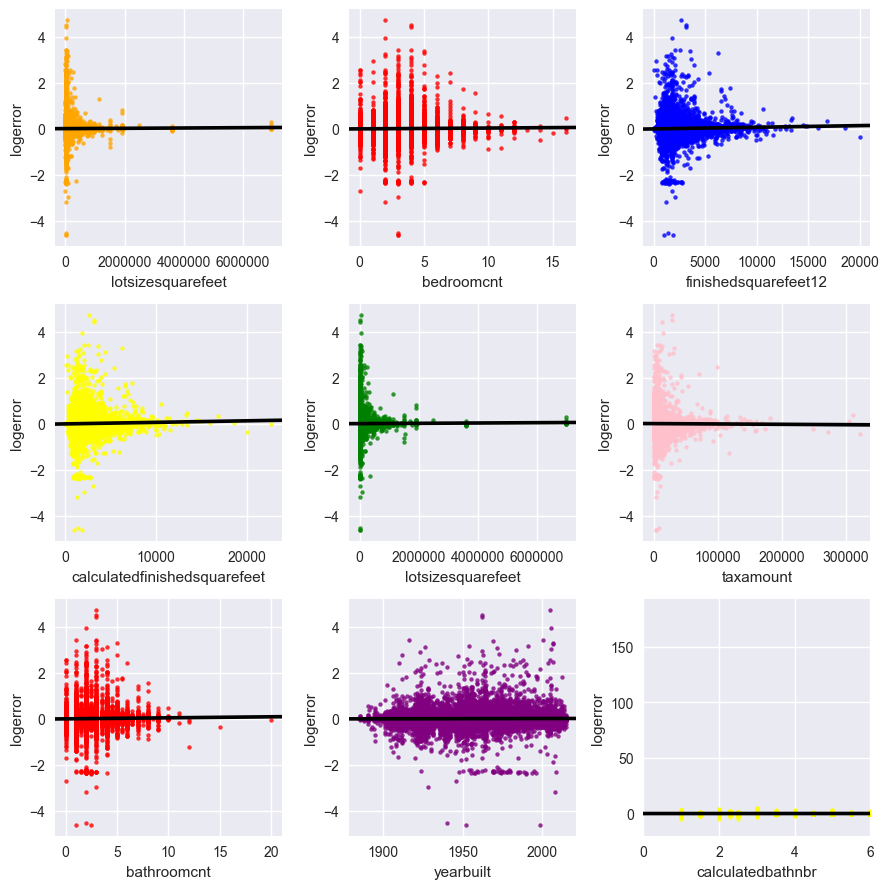

In [11]:
#Plot 2: scatter plots 
fig  = plt.figure(figsize=(9, 9), dpi=100);

#fig.suptitle('House Characteristics')

axes1 = fig.add_subplot(331); axes2 = fig.add_subplot(332); axes3 = fig.add_subplot(333); 
axes4 = fig.add_subplot(334); axes5 = fig.add_subplot(335); axes6 = fig.add_subplot(336); 
axes7 = fig.add_subplot(337); axes8 = fig.add_subplot(338); axes9 = fig.add_subplot(339); 

sns.regplot(x='lotsizesquarefeet', y='logerror', data=merged, ax=axes1, scatter_kws={"s": 10, "color":"orange"}, line_kws={"color":"black"});
sns.regplot(x='bedroomcnt', y='logerror', data=merged, ax=axes2, scatter_kws={"s": 10, "color":"red"}, line_kws={"color":"black"});
sns.regplot(x='finishedsquarefeet12', y='logerror', data=merged, ax=axes3, scatter_kws={"s": 10, "color":"blue"}, line_kws={"color":"black"});
sns.regplot(x='calculatedfinishedsquarefeet', y='logerror', data=merged, ax=axes4, scatter_kws={"s": 10, "color":"yellow"}, line_kws={"color":"black"});
sns.regplot(x='lotsizesquarefeet',  y='logerror', data=merged, ax=axes5, scatter_kws={"s": 10, "color":"green"}, line_kws={"color":"black"});
sns.regplot(x='taxamount', y='logerror', data=merged, ax=axes6, scatter_kws={"s": 10, "color":"pink"}, line_kws={"color":"black"});
sns.regplot(x='bathroomcnt',y='logerror', data=merged, ax=axes7, scatter_kws={"s": 10, "color":"red"}, line_kws={"color":"black"});
sns.regplot(x='yearbuilt',  y='logerror', data=merged, ax=axes8, scatter_kws={"s": 10, "color":"purple"}, line_kws={"color":"black"});
sns.regplot(x='calculatedbathnbr', y='logerror', data=merged, ax=axes9, scatter_kws={"s": 10, "color":"yellow"}, line_kws={"color":"black"});

axes9.set_xlim(0, 6)

fig.tight_layout();

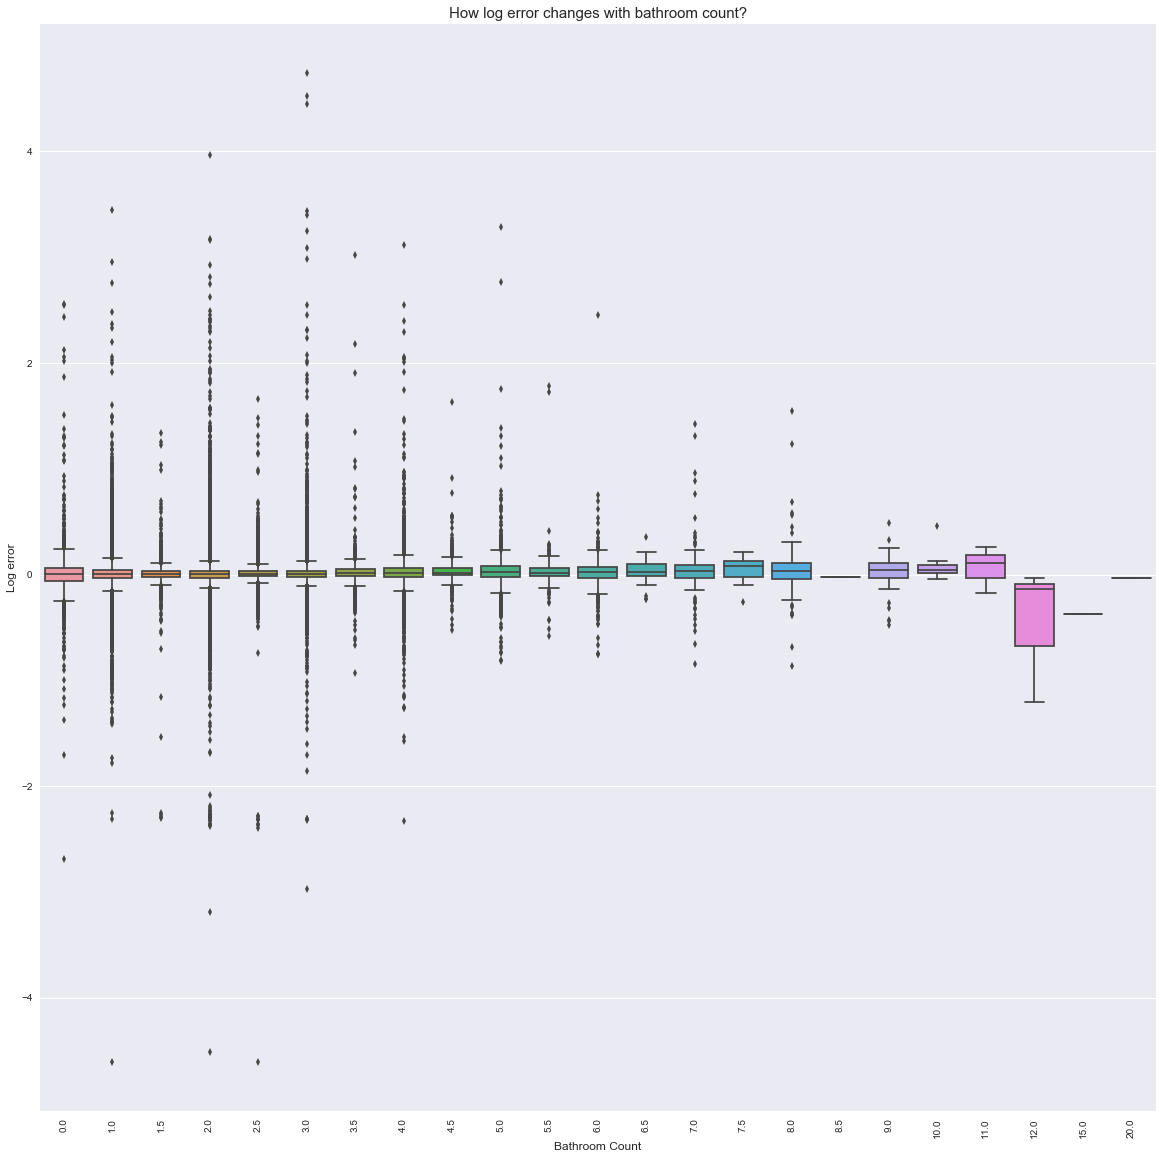

In [12]:
#Plot 3
#box plot for bathroom count

plt.figure(figsize=(20,20))
sns.boxplot(x="bathroomcnt", y="logerror", data=merged)
plt.ylabel('Log error', fontsize=12)
plt.xlabel('Bathroom Count', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("How log error changes with bathroom count?", fontsize=15)
plt.show()

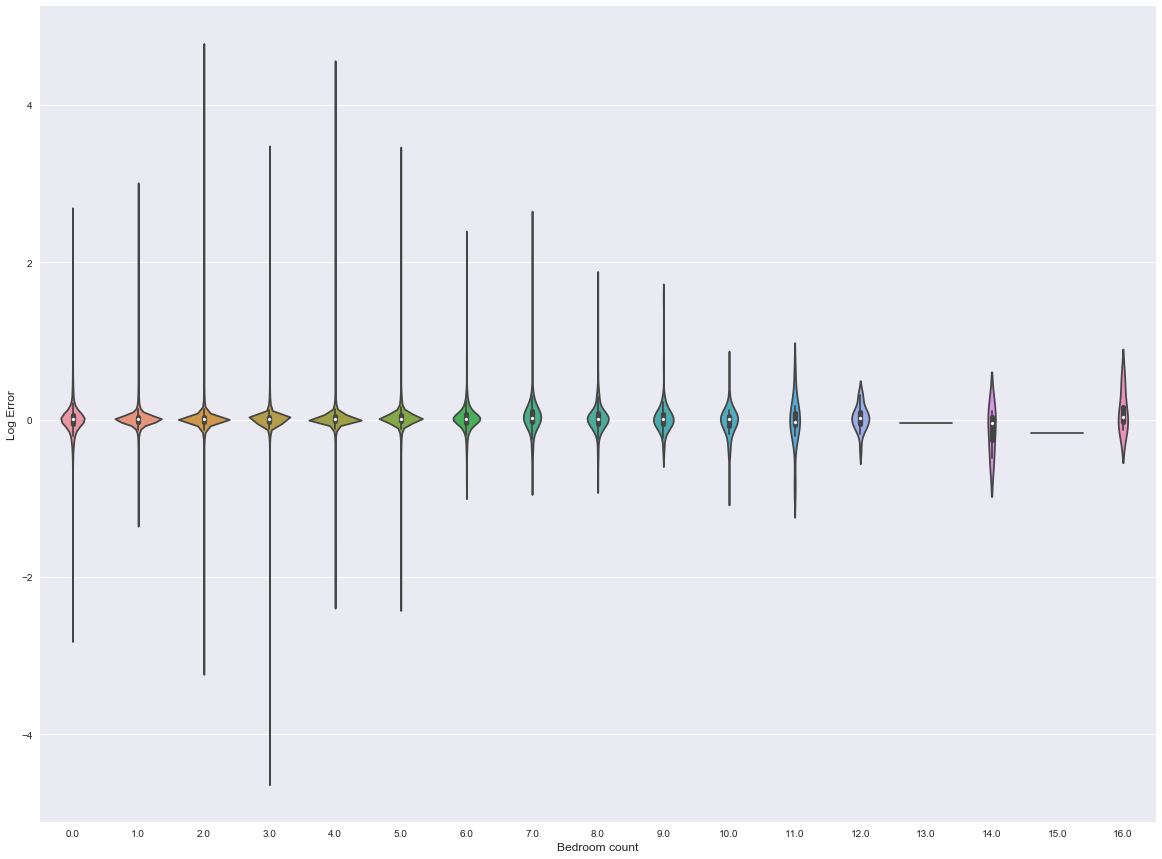

In [13]:
#Plot 4

plt.figure(figsize=(20,15))
sns.violinplot(x='bedroomcnt', y='logerror', data=merged)
plt.xlabel('Bedroom count', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

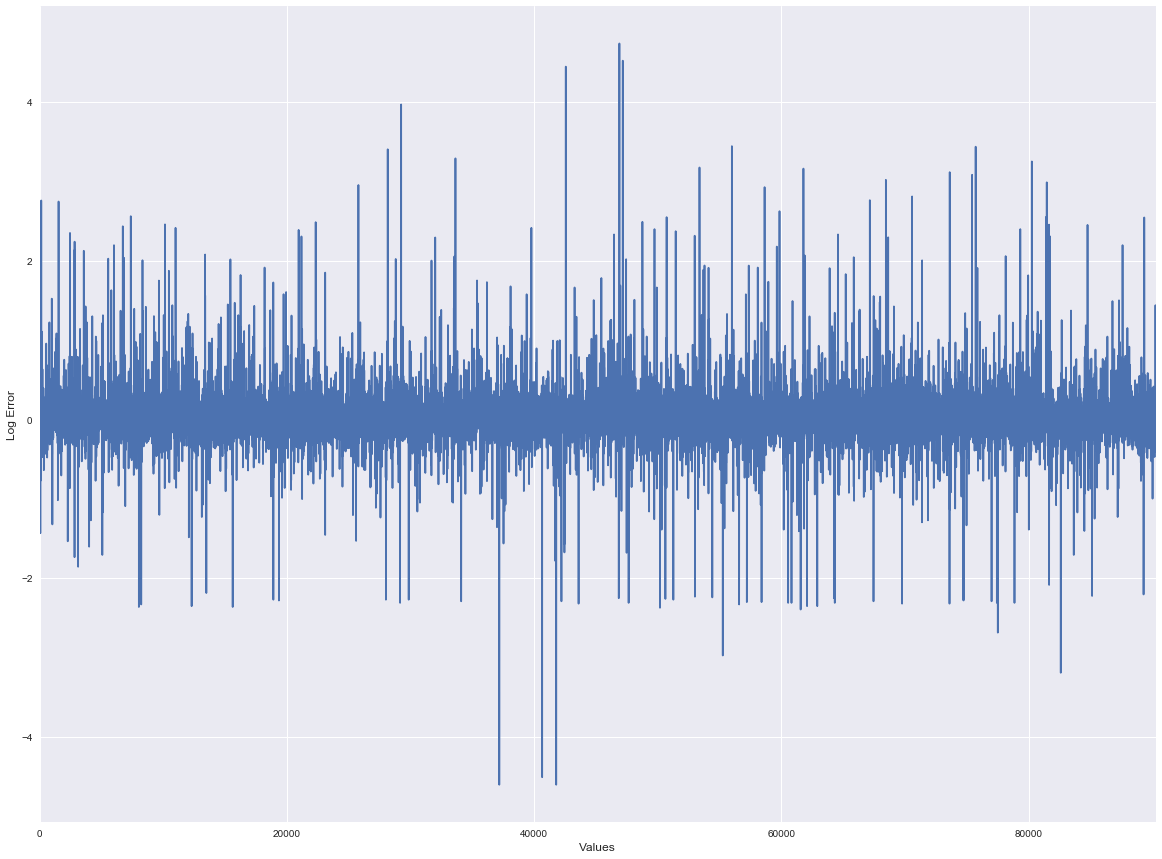

In [14]:
#Plot 5
#Let's plot the distribution of log error
plt.figure(figsize=(20,15))
sns.tsplot(data=merged['logerror'])
plt.xlabel('Values', fontsize=12)
plt.ylabel('Log Error', fontsize=12)
plt.show()

In [15]:
# drop parcel id and transaction date to evaluate correaltion

output_new = merged.drop(['parcelid', 'transactiondate'], axis=1)

In [16]:
output_new.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,5.784787,2.5,1264.0,1264.0,6111.0,2.0,4.012053,34303597.0,...,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,5.784787,1.0,777.0,777.0,6111.0,1.0,4.012053,34272866.0,...,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,5.784787,2.0,1101.0,1101.0,6111.0,2.0,4.012053,34340801.0,...,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,5.784787,1.5,1554.0,1554.0,6111.0,1.0,4.012053,34354313.0,...,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,5.784787,2.5,2415.0,2415.0,6111.0,2.0,4.012053,34266578.0,...,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


# Correlation calculations

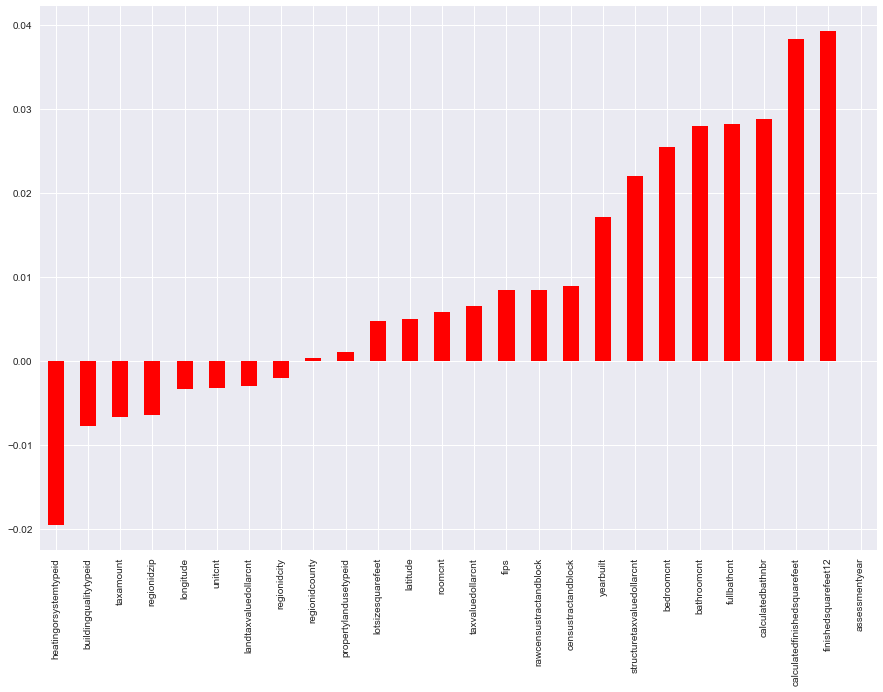

In [17]:
#plot correlation of each reamining column with logerror

corr_data=output_new.corr().ix['logerror', :-1].sort_values()
    
corr_data.plot.bar(figsize=(15,10), color='red') 

In [18]:
x_cols = [col for col in output_new.columns if col not in ['logerror'] if output_new[col].dtype=='float64']
labels = []
values = []
for col in x_cols:
    labels.append(col)
    values.append(np.corrcoef(output_new[col].values, output_new.logerror.values)[0,1])
corr_df = pd.DataFrame({'col_labels':labels, 'corr_values':values}).sort_values(by='corr_values')

In [19]:
#As we can see, overall correlation values are very small. Let us take the variables with high correlation values.

corr_high = corr_df.ix[(corr_df['corr_values']>0.01) | (corr_df['corr_values'] < -0.005)]
corr_high

,col_labels,corr_values
8,heatingorsystemtypeid,-0.019605
2,buildingqualitytypeid,-0.007733
24,taxamount,-0.006671
16,regionidzip,-0.006499
19,yearbuilt,0.017127
20,structuretaxvaluedollarcnt,0.021999
1,bedroomcnt,0.025467
0,bathroomcnt,0.027889
7,fullbathcnt,0.028169
3,calculatedbathnbr,0.028759


<p>The highest correlation is shown by "finishedsqaurefeet12" feature and the most negative is shown by "heatingsystemtypeid"</p>

In [20]:
#Columns to use for plotting heatmap i.e. columns with high correlations:

corr_heatmap = corr_high.col_labels.tolist()

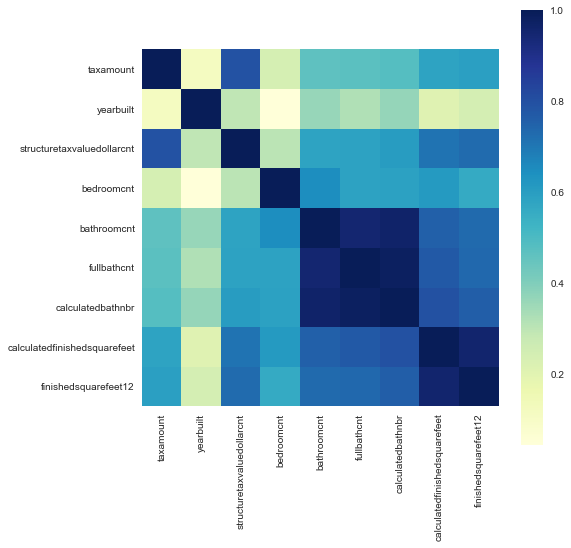

In [21]:
# Let us draw the heatmap to see the correlations among variables 
category_value = ['airconditioningtypeid','architecturalstyletypeid','buildingqualitytypeid','buildingclasstypeid','decktypeid','fips','hashottuborspa','heatingorsystemtypeid','pooltypeid10','pooltypeid2','pooltypeid7','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip','storytypeid','typeconstructiontypeid','taxdelinquencyflag']

numeric_col = [x for x in corr_heatmap if x not in category_value]

#The following heatmap shows what all variables are correlated.
plt.figure(figsize = (8,8))

sns.heatmap(data=output_new[numeric_col].corr(), vmax=1., square=True,cmap="YlGnBu")

plt.show()

plt.gcf().clear()

In [22]:
categorical_value = ['airconditioningtypeid','buildingqualitytypeid','fips','heatingorsystemtypeid','propertycountylandusecode','propertylandusetypeid','propertyzoningdesc','rawcensustractandblock','regionidcity','regionidcounty','regionidneighborhood','regionidzip']


In [23]:
output_new.head()

,bathroomcnt,bedroomcnt,buildingqualitytypeid,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fips,fullbathcnt,heatingorsystemtypeid,latitude,...,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,5.784787,2.5,1264.0,1264.0,6111.0,2.0,4.012053,34303597.0,...,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,5.784787,1.0,777.0,777.0,6111.0,1.0,4.012053,34272866.0,...,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,5.784787,2.0,1101.0,1101.0,6111.0,2.0,4.012053,34340801.0,...,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,5.784787,1.5,1554.0,1554.0,6111.0,1.0,4.012053,34354313.0,...,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,5.784787,2.5,2415.0,2415.0,6111.0,2.0,4.012053,34266578.0,...,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


<p> Let us drop all the categorical values to proceed to linear regression</p>

In [24]:
drop_col = [x for x in output_new.columns if x in categorical_value]
output_new = output_new.drop(drop_col, axis=1)

In [25]:
output_new.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,latitude,longitude,lotsizesquarefeet,roomcnt,unitcnt,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror
0,2.5,3.0,2.5,1264.0,1264.0,2.0,34303597.0,-119287236.0,1735.000000,5.0,1.181171,1986.0,115087.0,191811.0,2015.0,76724.0,2015.06,6.111002e+13,0.0953
1,1.0,2.0,1.0,777.0,777.0,1.0,34272866.0,-119198911.0,22822.805528,4.0,1.181171,1990.0,143809.0,239679.0,2015.0,95870.0,2581.30,6.111002e+13,0.0198
2,2.0,3.0,2.0,1101.0,1101.0,2.0,34340801.0,-119079610.0,6569.000000,5.0,1.181171,1956.0,33619.0,47853.0,2015.0,14234.0,591.64,6.111001e+13,0.0060
3,1.5,2.0,1.5,1554.0,1554.0,1.0,34354313.0,-119076405.0,7400.000000,5.0,1.181171,1965.0,45609.0,62914.0,2015.0,17305.0,682.78,6.111001e+13,-0.0566
4,2.5,4.0,2.5,2415.0,2415.0,2.0,34266578.0,-119165392.0,6326.000000,8.0,1.181171,1984.0,277000.0,554000.0,2015.0,277000.0,5886.92,6.111001e+13,0.0573


In [26]:
#we need logerror in the final output for linear regression, hence retaining it
corr_heatmap.append('logerror')

low_corr=[x for x in output_new.columns if x not in corr_heatmap]
output_new=output_new.drop(low_corr, axis=1)

In [27]:
output_new.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount,logerror
0,2.5,3.0,2.5,1264.0,1264.0,2.0,1986.0,115087.0,2015.06,0.0953
1,1.0,2.0,1.0,777.0,777.0,1.0,1990.0,143809.0,2581.30,0.0198
2,2.0,3.0,2.0,1101.0,1101.0,2.0,1956.0,33619.0,591.64,0.0060
3,1.5,2.0,1.5,1554.0,1554.0,1.0,1965.0,45609.0,682.78,-0.0566
4,2.5,4.0,2.5,2415.0,2415.0,2.0,1984.0,277000.0,5886.92,0.0573


# Linear Regression

In [28]:
x_pre_train=output_new.drop('logerror',axis=1)
y_pre_train=output_new['logerror']

x_train, x_test, y_train, y_test = train_test_split(x_pre_train, y_pre_train, test_size=0.20)


In [29]:
regression = linear_model.LinearRegression()

# Train the model using the training sets
regression.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [30]:
#predict on test data (20%)
y_prediction = regression.predict(x_test)

print('Coefficients: \n', regression.coef_)
# The mean squared error
print("Mean squared error: %.6f"
      % mean_squared_error(y_test, y_prediction))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.6f' % r2_score(y_test, y_prediction))


Coefficients: 
 [ -1.38389226e-03   1.10121077e-04  -3.49605057e-03   2.22649787e-06
   7.05995235e-06   3.63003080e-03   3.34590928e-05   2.97403160e-08
  -1.41121073e-06]
Mean squared error: 0.021351
Variance score: 0.005693


In [31]:
prop_test=property_data[x_train.columns]
prop_test.head()

,bathroomcnt,bedroomcnt,calculatedbathnbr,calculatedfinishedsquarefeet,finishedsquarefeet12,fullbathcnt,yearbuilt,structuretaxvaluedollarcnt,taxamount
0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.0,0.0,NaN,73026.0,NaN,NaN,NaN,650756.0,20800.37
3,0.0,0.0,NaN,5068.0,NaN,NaN,1948.0,571346.0,14557.57
4,0.0,0.0,NaN,1776.0,NaN,NaN,1947.0,193796.0,5725.17


In [32]:
for column in prop_test.columns:
    prop_test[column]=prop_test[column].fillna(prop_test[column].mean())

In [33]:
# Make predictions using the testing set

prop_prediction = regression.predict(prop_test)

In [34]:
submission = pd.read_csv("../Desktop/Zillow/sample_submission.csv") 
#Read Sample_submission file

In [35]:
for col in submission.columns:
    if col!='ParcelId':
        submission[col]=prop_prediction

In [36]:
submission.head()

,ParcelId,201610,201611,201612,201710,201711,201712
0,10754147,0.014987,0.014987,0.014987,0.014987,0.014987,0.014987
1,10759547,0.014987,0.014987,0.014987,0.014987,0.014987,0.014987
2,10843547,0.166018,0.166018,0.166018,0.166018,0.166018,0.166018
3,10859147,0.020613,0.020613,0.020613,0.020613,0.020613,0.020613
4,10879947,0.014486,0.014486,0.014486,0.014486,0.014486,0.014486


In [37]:
submission.to_csv("../Desktop/Zillow/LinearRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

# Random Forest Model

In [38]:
# Now let us proceed to another model :random forest model

# X, y = make_regression(n_features=4, n_informative=2, random_state=0, shuffle=False)
random_rgr = RandomForestRegressor()
random_rgr.fit(x_train, y_train)
RandomForestRegressor(bootstrap=True,criterion='mse',max_depth=2,max_features='auto', max_leaf_nodes=None, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
print(random_rgr.feature_importances_)

[ 0.01901338  0.04008815  0.01739258  0.13019055  0.11485698  0.01215636
  0.11068593  0.27552542  0.28009064]


In [39]:
prop_random_pred = random_rgr.predict(prop_test)

In [40]:
submission_random = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_random.columns:
    if col!='ParcelId':
        submission_random[col]=prop_random_pred
submission_random.to_csv("../Desktop/Zillow/RandomForestRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

# Gradient Boosting Model

In [41]:
#Trying yet another model: Gradient Boosting regression

# #############################################################################
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(x_train, y_train)
prop_gradient_pred= clf.predict(prop_test)


In [42]:
submission_gradient = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_gradient.columns:
    if col!='ParcelId':
        submission_gradient[col]=prop_gradient_pred
submission_gradient.to_csv("../Desktop/Zillow/GradientBoostingRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

# LightGBM Regression Model

In [43]:
#trying yet another model: LigthGBM
# create dataset for lightgbm
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test, reference=lgb_train)

params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'mse'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

# train
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

# predict
prop_lightgbm_pred = gbm.predict(prop_test, num_iteration=gbm.best_iteration)

[1]	valid_0's l2: 0.0214598	valid_0's l2: 0.0214598
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.0214439	valid_0's l2: 0.0214439
[3]	valid_0's l2: 0.021435	valid_0's l2: 0.021435
[4]	valid_0's l2: 0.021425	valid_0's l2: 0.021425
[5]	valid_0's l2: 0.0214129	valid_0's l2: 0.0214129
[6]	valid_0's l2: 0.0214025	valid_0's l2: 0.0214025
[7]	valid_0's l2: 0.0214006	valid_0's l2: 0.0214006
[8]	valid_0's l2: 0.0214009	valid_0's l2: 0.0214009
[9]	valid_0's l2: 0.021396	valid_0's l2: 0.021396
[10]	valid_0's l2: 0.021399	valid_0's l2: 0.021399
[11]	valid_0's l2: 0.0213857	valid_0's l2: 0.0213857
[12]	valid_0's l2: 0.021372	valid_0's l2: 0.021372
[13]	valid_0's l2: 0.0213684	valid_0's l2: 0.0213684
[14]	valid_0's l2: 0.021357	valid_0's l2: 0.021357
[15]	valid_0's l2: 0.0213522	valid_0's l2: 0.0213522
[16]	valid_0's l2: 0.0213486	valid_0's l2: 0.0213486
[17]	valid_0's l2: 0.0213488	valid_0's l2: 0.0213488
[18]	valid_0's l2: 0.0213429	valid_0's l2: 0.0213429
[19]	v

In [44]:
submission_lightgbm = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_lightgbm.columns:
    if col!='ParcelId':
        submission_lightgbm[col]=prop_lightgbm_pred
submission_lightgbm.to_csv("../Desktop/Zillow/LightgbmRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

# Combination of Linear Regression and LightGBM

In [45]:
submission_combine = pd.read_csv("../Desktop/Zillow/sample_submission.csv") #Read Sample_submission file
for col in submission_combine.columns:
    if col!='ParcelId':
        submission_combine[col]=0.5*prop_lightgbm_pred + 0.5*prop_prediction
submission_combine.to_csv("../Desktop/Zillow/CombineRegression.csv.gz", index=False, compression='gzip', float_format='%.6f')

In [46]:
prop_prediction

array([ 0.01498668,  0.01498668,  0.16601753, ...,  0.01226962,
        0.01226962,  0.01226962])

# Report

We started with our data analysis as the first step. We analysed various interesting aspects of this dataset. For example, the maximum number of house transactions happened in the month of June. Before any further data analysis, we needed to clean the data and handle the missing values intelligently. 

<b>How did I handle the missing data?</b>

First of all, I checked the number fo missing values in each column. Having found that, I dropped off the columns which had more than 50% missing data. Now,out of the remaining dataset, I replaced the missing values with mean value of that column for each column. Before being able to replace with mean or even evaluate the mean, I had to make sure that all the columnd were of the type numeric so that the mean evaluation makes sense. 

<b>Merging the train and property dataset</b>

After dealing with the missing values in the data, I merged the two given datasets- train dataset and property dataset over the column 'ParcelId'. Now, we are ready to dive deeper into further analysis for correlation and heatmap plotting.

We analysed different features, how they were distributed with logerror values. We plotted different plots to display the dependecies.

<b>Finding the correlation values and draw the heatmap</b>

To find the correlation , we first had to remove all the categorical columns as thy do not contribute in plotting correlations and gave erraneous results. After removing all the categorical values, we were left mainly with the numerical columns. Finally we plotted the bar chart of correlations and discovered that the over all correlations were really very low in all cases. Hence, we did not find very high correlation between any features.

<b>Filtering out the features having very low correlation with logerror<b/>

From the heatmap, we realized that some features were rally redundant for linear regression as they had extremely low correlation values. Hence, we had to drop these columns as well prior to th e linear regression of the final output dataset.

# Linear Regression Model

Finally after all th above steps, we proceeded with linear regression model for our prediction model. I used sklearn library for the same. 

I divided the fina output data (merged train and property data) into 80% training set and 20% test set. I built my linear regressor model on 80% train data and tested it's validation on the remaining 20% test data.

<b>Results from Linear Regression:</b>

Mean squared error: 0.028639

Variance score: 0.003542

Kaggle Score: 0.0650163

Kaggle rank: 2222

# Random Forest Model

After linear regression model, I tried random forest model. But, to my surprise, I found that this performed even worse than the linear regression model. Following are the results obtained:

Kaggle Score:0.0829437

Kaggle rank: 2222

# Gradient Boosting Model

This model also did not improve upon Linear regression model. Though it performed better than the random forest model.

Following are the results obtained:

Kaggle Score:0.0654311

Kaggle rank: 2222

# LightGBM Regression Model

This model also did not improve upon Linear regression model. Though it performed better than the random forest model anmd Gradient Boosting Model.


Following are the results obtained:

Kaggle Score: 0.0651120

Kaggle rank: 2222

# Combination of Linear Regression and LightGBM

Since all the above models did not improve upon the linear regression model, I finally tried, a combination of linear Regression and LightGBM. What I tried here was summing up half the value of predictions made by linear regression model and half the value of predictions made by LightGBM (the two best models till now). 

This finally did improve the output a little bit as shown by the following results:

Kaggle Score: 0.0649504

Kaggle rank: 2153 (final rank on leaderboard now)